<a href="https://colab.research.google.com/github/jjone36/Colab/blob/master/easiest_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference from:
- [Image Classifier - Cats🐱 vs Dogs🐶](https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8)
- [Kaggle Kernels](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification/notebook)

# Basic Tutorial of CNN

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

['train', 'sampleSubmission.csv', 'test1']


## 1. importing data

In [0]:
filenames = os.listdir('../input/train/train')

In [0]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# print the categories
print(categories[0:10])

[0, 1, 1, 1, 1, 1, 1, 0, 0, 0]


Since this is supervised learning, we need labeling the images. Categories 0 indicates cats and 1 indicates dogs. 

In [0]:
# transform into dataframe 
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})
df.head()

,filename,category
0,cat.11679.jpg,0
1,dog.2811.jpg,1
2,dog.2578.jpg,1
3,dog.9238.jpg,1
4,dog.7504.jpg,1


Let's make a validation set from the training set

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size = .2, random_state = 30)
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)
print(len(train_df), len(val_df))

20000 5000


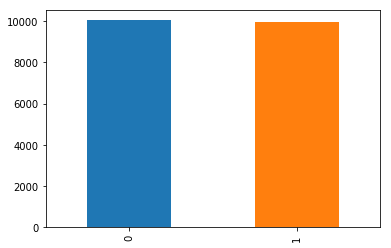

In [0]:
train_df['category'].value_counts().plot(kind = 'bar')

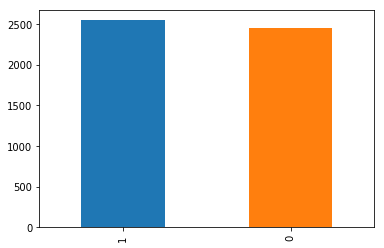

In [0]:
val_df['category'].value_counts().plot(kind = 'bar')

## 2. Simple Modeling

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization 

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
im_size = (im_width, im_height)

In [0]:
# model initilaize
model = Sequential()

In [0]:
# ConvNet_1
model.add(Conv2D(32, (3, 3), input_shape = (im_width, im_height, 3), 
                 activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

In [0]:
# ConvNet_2
model.add(Conv2D(32, kernel_size= 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

In [0]:
# Flattening 
model.add(Flatten())

In [0]:
# Full-connected layers
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 1, activation = 'sigmoid'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# Optimization
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
__________

## 3. Image Agumentation

In [0]:
batch_size = 30

In [0]:
from keras.preprocessing.image import ImageDataGenerator

Data Augmentation not to have overfitting

In [0]:
# Augmentation with trainset
train_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_gen.flow_from_dataframe(
    train_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size= im_size,
    class_mode='binary',
    batch_size= batch_size
)

Found 20000 images belonging to 2 classes.


In [0]:
# Augmentation with valid set
val_gen = ImageDataGenerator(rescale = 1./255)

val_generator = val_gen.flow_from_dataframe(
    val_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size= im_size,
    class_mode='binary',
    batch_size= batch_size
)

Found 5000 images belonging to 2 classes.


## 4. Callbacks

In [0]:
# Early stopeer
from keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(patience = 10)

In [0]:
# Learning rate reduction
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduce = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [early_stopper, learning_rate_reduce]

## 5. Fitting

In [0]:
# fitting
history = model.fit_generator(train_generator,
                    epochs = 50,
                    validation_data = val_generator,
                    validation_steps = val_df.shape[0] // batch_size, 
                    steps_per_epoch= train_df.shape[0] // batch_size,
                    callbacks = callbacks)

Epoch 1/50
666/666 [==============================] - 212s 319ms/step - loss: 0.6544 - acc: 0.6734 - val_loss: 1.4487 - val_acc: 0.3135
Epoch 2/50
666/666 [==============================] - 165s 248ms/step - loss: 0.4990 - acc: 0.7536 - val_loss: 1.8163 - val_acc: 0.2491
Epoch 3/50
666/666 [==============================] - 165s 248ms/step - loss: 0.4527 - acc: 0.7869 - val_loss: 2.0399 - val_acc: 0.2352

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
666/666 [==============================] - 165s 247ms/step - loss: 0.3997 - acc: 0.8180 - val_loss: 2.1828 - val_acc: 0.2014
Epoch 5/50
666/666 [==============================] - 163s 245ms/step - loss: 0.3799 - acc: 0.8288 - val_loss: 2.4622 - val_acc: 0.2229

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/50
666/666 [==============================] - 164s 247ms/step - loss: 0.3492 - acc: 0.8437 - val_loss: 2.3275 - val_acc: 0.2044
Epoch 7/50
666/666 [==

## 6. Model saving

In [0]:
model.save_weights('model.h5')

NameError: name 'history' is not defined

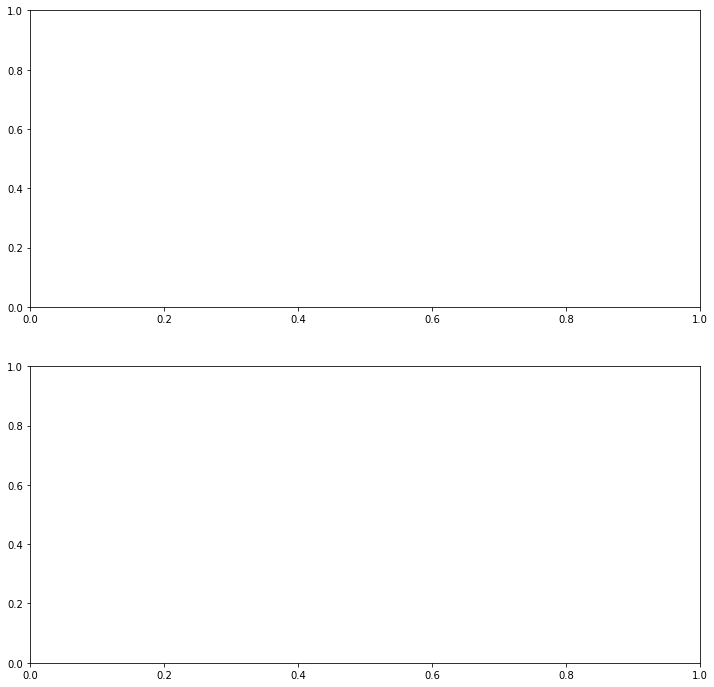

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## 7. Prediction

In [0]:
# loading test set
test_filenames = os.listdir("../input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [0]:
# Augmentation with test set
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [0]:
# Prediction
predict = model.predict_generator(test_generator, 
                                  steps=np.ceil(nb_samples/batch_size))

test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > .5, 1,0)

In [0]:
# Distribution of prediction
test_df['category'].value_counts().plot(kind = 'bar')